In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clean
import process
#import pytorchPipeline
import pandas as pd
import numpy as np
import train_test_split
import scipy as sp

In [2]:
def get_ratings(style = 'range', threshold = 2.5):
    """Gets the ratings/interaction/user-item matrix
    in the form we need to apply the model.

    Parameters
    ----------
    style: str, optional
        Options: 'range', 'pos_neg', 'zero_one'
        The format of the ratings matrix (see process.py)
        Defaults to 'range'
    threshold: int, optional
        The cutoff threshold for "liking" a beer; only
        matters if style = 'pos_neg' or style = 'zero_one'
        (see process.py)
        Defaults to 2.5
    """
    if style not in ['range', 'pos_neg', 'zero_one']:
        raise Exception('Not a valid choice for style.')
        
    reviews = pd.read_csv('https://query.data.world/s/55cb4g2ccy2sbat45jzrwmfjfkp2d5?dws=00000')
    reviews.review_time = pd.to_datetime(reviews.review_time,unit = 's')
    clean_reviews = clean.remove_null_rows(reviews)
    clean_reviews = clean.remove_dup_beer_rows(clean_reviews)
    clean_reviews = clean.merge_similar_name_breweries(clean_reviews)
    clean_reviews = clean.merge_brewery_ids(clean_reviews)
    
    if style == 'range':
        return process.InteractionMatrixTransformer(clean_reviews).to_range().tocsr()
    if style == 'pos_neg':
        return process.InteractionMatrixTransformer(clean_reviews).to_positive_negative(threshold).tocsr()
    if style == 'zero_one':
        return process.InteractionMatrixTransformer(clean_reviews).to_zero_one(threshold).tocsr()

In [3]:
class MatrixFactorization(torch.nn.Module):
    """Matrix factorization model.

    - Initializes user and item embeddings (default to dimension 10).
    - Forward pass is just a dot product between user and item latent vectors.
    """
    def __init__(self, num_users, num_items, emb_size = 10):
        super().__init__()
        self.user_emb = torch.nn.Embedding(num_users, emb_size)
        self.item_emb = torch.nn.Embedding(num_items, emb_size)
        # initializing weights
        self.user_emb.weight.data.uniform_(0,1)
        self.item_emb.weight.data.uniform_(0,1)

    def forward(self, user, item):
        return (self.user_emb(user) * self.item_emb(item)).sum(1)

In [4]:
def train_epochs(model, int_matrix, epochs = 10, lr = 0.001, wd = 0.0):
    """Trains the matrix factorization model.

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to train
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    epochs: int, optional
        Number of epochs in training
        Default is 10
    lr: float, optional
        Learning rate
        Default is 0.001
    wd: float, optional
        Weight decay
        Default is 0.0
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)  # learning rate
    for i in range(epochs):
        model.train() # put model in training mode (?)
        
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Get mse for nonzero entries
        rows, cols = int_matrix.nonzero() # (rows[i], cols[i]) across all i will be the coordinates of all nonzero entries of ratings.

        pred = model(torch.tensor(rows), torch.tensor(cols))
        actual = torch.tensor(int_matrix[rows, cols], dtype = torch.float32).squeeze() # squeeze just reshapes to the appropriate dim
        
        loss = F.mse_loss(pred, actual)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
            
        print("After %.0f epochs, train loss %.10f" % (i + 1,loss.item()))
    print('Final RMSE: %.4f' % loss.item()**(1/2))

In [5]:
def standard_training(model, int_matrix, initial_lr = 0.01, decay_rate = 0.98, epochs = 100, wd = 0.0):
    """Standardizes training for matrix factorization
    models with learning rate decaying as:
    initial_lr * decay_rate^epoch
    Stick to the default inputs to standardize training!

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to train
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    epochs: int, optional
        Number of epochs in training
        Default is 10
    initial_lr: float, optional
        Learning rate
        Default is 0.01
    decay_rate: float, optional
        Decay rate
        Default is 1.0
    wd: float, optional
        Weight decay
        Default is 0.0
    """
    model.train() # put model in training mode (?)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = decay_rate)
    for i in range(epochs):
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Get mse for nonzero entries
        rows, cols = int_matrix.nonzero() # (rows[i], cols[i]) across all i will be the coordinates of all nonzero entries of ratings.

        pred = model(torch.tensor(rows), torch.tensor(cols))
        actual = torch.tensor(int_matrix[rows, cols], dtype = torch.float32).squeeze() # squeeze just reshapes to the appropriate dim
        
        loss = F.mse_loss(pred, actual)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        scheduler.step()
            
        if i % 10 == 0:
            print("After %.0f epochs, train loss %.10f" % (i, loss.item()))
    print('Final RMSE: %.4f' % loss.item()**(1/2))

In [6]:
int_matrix = get_ratings()

In [7]:
def recall_at_k_range(model, int_matrix, user, threshold = 2.5, k = 10):
    """Compute recall at k for a given user in the case
    where the ratings matrix was built using to_range.
    This is the ratio of number of items the user 
    actually liked (determined by threshold) in the 
    top k predictions made by the model over the total 
    number of items the user actually liked.

    Parameters
    ----------
    int_matrix: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    user: int
        The index of the user for whom you want to compute recall at k
    threshold: float, optional
        The threshold used to determine if a user actually likes a beer
        Defaults to 2.5
    k: int, optional
        The k parameter
        Defaults to 10
    """
    num_items = int_matrix.shape[1]
    preds = model(torch.tensor(user), torch.arange(num_items)) # predicated ratings of all beers
    topk_inds = torch.topk(preds, k).indices # indices of the top k predictions
    
    # get indices of the liked beers
    x = torch.tensor(int_matrix[user].toarray()).squeeze()
    inds_of_liked_beers = torch.where(x > threshold, 1, 0).squeeze().nonzero() # puts 1 in indices where x > thresh, 0 else then gets the nonzero indices
    
    if inds_of_liked_beers.shape[0] == 0:
        #return 'no liked beers'
        return (0, 0) # is this how this should go??
    
    intersect = np.intersect1d(topk_inds, inds_of_liked_beers)
    #print(len(intersect), len(inds_of_liked_beers))
    return len(intersect)/min(k, len(inds_of_liked_beers)), len(inds_of_liked_beers)

In [8]:
def recall_at_k_nonrange(model, ratings, user, k = 10):
    """Compute recall at k for a given user in the case
    where the ratings matrix was built using to_zero_one
    or to_positive_negative. This is the ratio of number
    of items the user actually liked (appear with 1 for
    this user in the ratings matrix) in the top k predictions
    made by the model over the total number of items the user
    actually liked.

    Parameters
    ----------
    model: MatrixFactorization
        The instance of a matrix factorization model to be evaluated
    ratings: scipy.sparse._csr.csr_matrix
        The ratings/interaction/user-item matrix
    user: int
        The index of the user for whom you want to compute recall at k
    k: int, optional
        The k parameter
        Defaults to 10
    """
    num_items = ratings.shape[1]
    preds = model(torch.tensor(user), torch.arange(num_items)) # predicated ratings of all beers
    topk_inds = torch.topk(preds, k).indices # indices of the top k predictions
    
    # get indices of the liked beers
    x = torch.tensor(ratings[user].toarray())
    inds_of_liked_beers = torch.where(x == 1, 1, 0).squeeze().nonzero() # puts 1 in indices where x == 1, 0 else then gets the nonzero indices
    
    if inds_of_liked_beers.shape[0] == 0:
        #return 'no liked beers'
        return 0 # is this how this should be handled??
    
    intersect = np.intersect1d(topk_inds, inds_of_liked_beers)
    
    return len(intersect)/min(k, len(inds_of_liked_beers)) # we use len(inds_of_liked_beers) for the weighted avg part below.

In [9]:
def get_submatrix(original_matrix, indices):
    rows = indices[:,0]
    cols = indices[:,1]
    original_matrix_coo = sp.sparse.coo_matrix(original_matrix)
    new_indices = np.where((np.isin(original_matrix_coo.row, rows)) & (np.isin(original_matrix_coo.col, cols)))
    return sp.sparse.coo_matrix((original_matrix_coo.data[new_indices], (original_matrix_coo.row[new_indices], original_matrix_coo.col[new_indices])),
                       shape=original_matrix.shape)
    

In [10]:
def run_model_with_validation(int_matrix, threshold = 2.5, k = 10, latent_dim = 10):
    recall_vals = [0]*5
    preds = [0]*5
    num_users = int_matrix.shape[0]
    num_items = int_matrix.shape[1]
    i = 0
    for train, test in train_test_split.get_splits(int_matrix):
        
        print("Pass %d"%i)
        
        model = MatrixFactorization(num_users, num_items, emb_size=latent_dim)
        
        train_matrix = get_submatrix(int_matrix, train).tocsr()
        test_matrix = get_submatrix(int_matrix, test).tocsr()
        
        standard_training(model, train_matrix)
        #preds = model(torch.tensor(0), torch.arange(num_items)) # THIS DOESN'T SEEM RIGHT! THIS IS ONLY PREDICTING ON USER 0!
        #topk_inds = torch.topk(preds, k).indices
        recall = total_weighted_recall_at_k_range(model, sp.sparse.csr_matrix(test_matrix), threshold = threshold, k = k)
        print('Recall: ' + str(recall))
        recall_vals[i] = recall
        i += 1
    return recall_vals
        

In [11]:
def total_weighted_recall_at_k_range(model, int_matrix, threshold = 2.5, k = 10):
    num_users, num_items = int_matrix.shape
    
    recalls = torch.empty(num_users)
    weights = torch.empty(num_users)
    
    for user in range(num_users):
        recall_output = recall_at_k_range(model, int_matrix, user, threshold, k)
        recalls[user] = recall_output[0]
        weights[user] = recall_output[1]
        
    return (recalls*weights/weights.sum()).mean()

### Example code for subsetting a sparse matrix

In [12]:
import numpy as np
from scipy.sparse import coo_matrix

# Example row, column, and data arrays
rows = np.array([0, 1, 2, 1, 3])
cols = np.array([1, 2, 2, 0, 3])
data = np.array([4.2, 3.1, 1.5, 2.3, 5.7])

# Create the original sparse matrix
original_matrix = coo_matrix((data, (rows, cols)))
print(original_matrix.toarray())
# Specify the desired row and column indices for the subset
desired_rows = [1, 3]
desired_cols = [2, 3]

# Find the indices of non-zero elements in the specified rows and columns
subset_indices = np.where((np.isin(original_matrix.row, desired_rows)) & (np.isin(original_matrix.col, desired_cols)))

# Extract the subset of the sparse matrix
subset_matrix = coo_matrix((original_matrix.data[subset_indices], (original_matrix.row[subset_indices], original_matrix.col[subset_indices])),
                           shape=original_matrix.shape)

print(subset_matrix.toarray())


[[0.  4.2 0.  0. ]
 [2.3 0.  3.1 0. ]
 [0.  0.  1.5 0. ]
 [0.  0.  0.  5.7]]
[[0.  0.  0.  0. ]
 [0.  0.  3.1 0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  5.7]]


In [13]:
def grid_search(latent_dims): # latent dims is a list
    outs = [[] for _ in range(len(latent_dims))]
    # add other hyperparams to gridsearch over?
    for i, latent_dim in enumerate(latent_dims):
        outs[i].append(latent_dim)
        cross_vals = run_model_with_validation(int_matrix, threshold = 2.5, k = 10, latent_dim = latent_dim)
        outs[i].append(cross_vals)
        outs[i].append(sum(cross_vals)/len(cross_vals))
    return outs

In [14]:
grid_res = grid_search([5,10,20,50,100])
grid_res

Pass 0
After 0 epochs, train loss 7.7418966293
After 10 epochs, train loss 5.4788331985
After 20 epochs, train loss 3.8184077740
After 30 epochs, train loss 2.7128686905
After 40 epochs, train loss 2.0238120556
After 50 epochs, train loss 1.6038316488
After 60 epochs, train loss 1.3437095881
After 70 epochs, train loss 1.1766095161
After 80 epochs, train loss 1.0647858381
After 90 epochs, train loss 0.9870995879
Final RMSE: 0.9676
Recall: tensor(0.)
Pass 1
After 0 epochs, train loss 7.7372794151
After 10 epochs, train loss 5.4697809219
After 20 epochs, train loss 3.8056740761
After 30 epochs, train loss 2.6986651421
After 40 epochs, train loss 2.0104310513
After 50 epochs, train loss 1.5924394131
After 60 epochs, train loss 1.3344120979
After 70 epochs, train loss 1.1690559387
After 80 epochs, train loss 1.0585609674
After 90 epochs, train loss 0.9818593860
Final RMSE: 0.9652
Recall: tensor(5.6521e-09)
Pass 2
After 0 epochs, train loss 7.7410650253
After 10 epochs, train loss 5.4785933

Final RMSE: 1.0155
Recall: tensor(2.5918e-08)
Pass 3
After 0 epochs, train loss 78.0664978027
After 10 epochs, train loss 23.8472461700
After 20 epochs, train loss 7.5363302231
After 30 epochs, train loss 3.1436970234
After 40 epochs, train loss 1.9034060240
After 50 epochs, train loss 1.4792283773
After 60 epochs, train loss 1.2903608084
After 70 epochs, train loss 1.1849365234
After 80 epochs, train loss 1.1169834137
After 90 epochs, train loss 1.0694248676
Final RMSE: 1.0186
Recall: tensor(1.0178e-08)
Pass 4
After 0 epochs, train loss 77.8101043701
After 10 epochs, train loss 23.7237510681
After 20 epochs, train loss 7.4772052765
After 30 epochs, train loss 3.1126251221
After 40 epochs, train loss 1.8844337463
After 50 epochs, train loss 1.4659363031
After 60 epochs, train loss 1.2801126242
After 70 epochs, train loss 1.1765455008
After 80 epochs, train loss 1.1098418236
After 90 epochs, train loss 1.0631788969
Final RMSE: 1.0158
Recall: tensor(2.4013e-08)
Pass 0
After 0 epochs, tra

[[5,
  [tensor(0.), tensor(5.6521e-09), tensor(6.8212e-10), tensor(0.), tensor(0.)],
  tensor(1.2668e-09)],
 [10,
  [tensor(0.), tensor(0.), tensor(0.), tensor(1.1030e-09), tensor(2.8412e-09)],
  tensor(7.8884e-10)],
 [20,
  [tensor(0.), tensor(0.), tensor(4.5006e-09), tensor(1.4156e-09), tensor(0.)],
  tensor(1.1832e-09)],
 [50,
  [tensor(1.5859e-08),
   tensor(7.1428e-09),
   tensor(2.5918e-08),
   tensor(1.0178e-08),
   tensor(2.4013e-08)],
  tensor(1.6622e-08)],
 [100,
  [tensor(1.4233e-08),
   tensor(5.4936e-09),
   tensor(1.9376e-08),
   tensor(2.0531e-08),
   tensor(2.4029e-08)],
  tensor(1.6733e-08)]]

In [15]:
len(grid_res), len(grid_res[0])

(5, 3)

In [16]:
for i, dim in enumerate([5,10,20,50,100]):
    print(i, dim)

0 5
1 10
2 20
3 50
4 100


In [18]:
vals = [grid_res[i][2] for i in range(5)]

In [19]:
vals

[tensor(1.2668e-09),
 tensor(7.8884e-10),
 tensor(1.1832e-09),
 tensor(1.6622e-08),
 tensor(1.6733e-08)]

In [21]:
import matplotlib.pyplot as plt

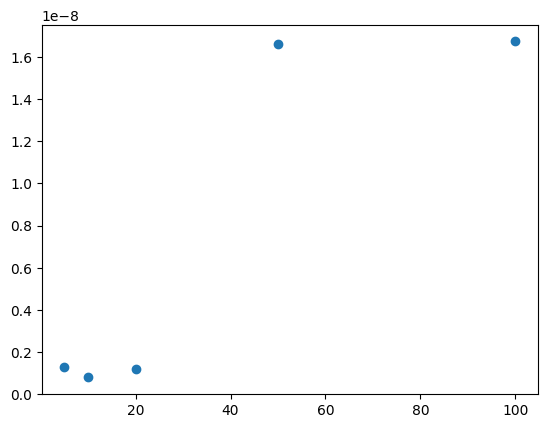

In [24]:
plt.scatter([5,10,20,50,100],vals)